<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# LSTM Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
from pandas import read_csv
import json
from matplotlib import pyplot
import math
import os
from os import listdir
from os.path import isfile, join
import numpy as np

In [0]:
# Prepare data
abcIndex = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']

gradeIndex = ['6A+', '6B', '6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+']


dataFiles = [f for f in listdir("sample_data") if isfile(join("sample_data", f))]

boulderProblemsMoves = []
bGrades = []
  
for dataFile in dataFiles:
  bProblemsPath = os.path.join("sample_data", dataFile)
  bGrade = dataFile.replace(".json","")
  bGradeIndex = gradeIndex.index(bGrade)
  gradeHotOne = [0] * len(gradeIndex)
  gradeHotOne[bGradeIndex] = 1
  
  with open(bProblemsPath) as jsonData:
      jsonRaw = jsonData.read()
      boulderProblems5 = json.loads(jsonRaw)

  exCount = len(boulderProblems5['Data'])

  eobVect = [0] * 199
  eobVect[198] = 1

  for i in range(0, exCount):
    moves = boulderProblems5['Data'][i]['Moves']
    moveCount = len(moves)
    boulderProblemMoves = []
    
    holdLocations = boulderProblems5['Data'][i]['Locations']
    holdCount = len(holdLocations)
    distances = []
    
    if(moveCount != holdCount):
      print("moveCount != holdCount")
    
    for j in range(0, moveCount):
      ## Get Hold Index
      hold = moves[j]['Description']
      letterIndex = abcIndex.index(hold[0])
      number = int(hold[1:])
      hotOneVect = [0] * 199 # 199 (distance)
      hotOneVect[((letterIndex * 18) + number - 1)] = 1
      boulderProblemMoves.append(hotOneVect)
      
      ## Get distance
      currentHoldLocation = holdLocations[j]
      if(j == 0):
        distances.append([0, 0, 0])
      else:
        oldHoldLocation = holdLocations[j-1]
        xDistance = currentHoldLocation['X'] - oldHoldLocation['X']
        yDistance = currentHoldLocation['Y'] - oldHoldLocation['Y']
        distance = math.sqrt(xDistance**2 + yDistance**2)
        distances.append([xDistance**2, yDistance**2, distance**2])
      ##
      
    # Add End Of Boulder vector
    boulderProblemMoves.append(eobVect)
    distances.append([0, 0, 0])
    
    # Only Distances
    # boulderProblemsMoves.append(distances)

    # Distances and Holds
    distancesFlat = [y for x in distances for y in x]
    distancesFlatMax = max(distancesFlat)
    #print(distancesFlatMax)
    distancesNorm = np.log(np.add(np.abs(distances), 1)) # np.divide(distances, 500)
    boulderProblemsMoves.append(np.concatenate((boulderProblemMoves, np.divide(distancesNorm, 5)), axis=1))

    # Only holds
    # boulderProblemsMoves.append(boulderProblemMoves)

    # y
    bGrades.append(bGradeIndex)

    # Shapes

In [0]:
# print(bGrades)
# print(boulderProblemsMoves)
print(len(boulderProblemsMoves))

max_length = max([len(s) for s in boulderProblemsMoves])
print(max_length)

X = np.array(boulderProblemsMoves)
Xpad = pad_sequences(X, maxlen=max_length, padding='post')

print(Xpad.shape)

y = np.array(bGrades)

1089
15
(1089, 15, 202)


In [0]:
# split into train and test sets
# Xpad = np.reshape(Xpad,(Xpad.shape[0],Xpad.shape[1],1))
RANDOM_SEED = 5
X_train, X_test, y_train, y_test = train_test_split(Xpad, y, test_size=0.2, random_state=RANDOM_SEED)

print("X_train")
print(X_train.shape)
print("X_test")
print(X_test.shape)
print(y_test)

X_train
(871, 15, 202)
X_test
(218, 15, 202)
[ 4  8  0 10  4  4  1  7  8 10  8  4  0  6  9  6  9  8  4  7  5 10  6  6
  7  9  3  7 10  7  9  5  6  5 10  4  4  5  5  8  4 10  5  6  0 10  8  6
  3  8  3  4  8  5  3  4  5 10  3  5  1  9  3 10  1  9  9  6  3  9  6  3
  0  8  8  3  0  7  7 10  9  2  3  0  8  3  9  7  6  3  2  2  3  8  4  9
  1  6  8  5  1  6  5  4  7  6  4  8  6  9  2  1  8  2  2  8  9  7  4  9
  1  6  7  7  3  4  4  5  6  5  6  9  2  4  8  4  5  0  3  4  3  8  4  4
  3  2  4  0  5  4  7  1  4  0  9  2  5  2  5  9  2  7  9  2  3  7  1  6
  5  3  6  5  9  7  6  4  2  2  9  0  8  0  6  2  4  0  6  7  5  9  1 10
  8 10  2  2 10  5 10  4  7  4  5  9  8  2  0  1  0  8  3  2  8  8  1  4
  5  9]


In [0]:
print(X_train.shape[1])
print(X_train.shape[2])
# Model
model = Sequential()
# first hidden layer
model.add(LSTM(input_shape=(X_train.shape[1], X_train.shape[2]), units=30, return_sequences=True))
model.add(Dropout(0.2))
# second hidden layer
model.add(LSTM(20, return_sequences=False))
model.add(Dropout(0.2))
# 1 neuron in the output layer
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mae', optimizer='adam')

15
202


In [0]:
# fit network
history = model.fit(X_train, 
                    y_train, 
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    verbose=2, 
                    shuffle=False)
model.summary()

Train on 871 samples, validate on 218 samples
Epoch 1/50
 - 13s - loss: 4.4578 - val_loss: 4.0245
Epoch 2/50
 - 0s - loss: 3.4005 - val_loss: 2.6479
Epoch 3/50
 - 0s - loss: 2.8793 - val_loss: 2.4716
Epoch 4/50
 - 0s - loss: 2.8548 - val_loss: 2.4693
Epoch 5/50
 - 0s - loss: 2.8749 - val_loss: 2.4976
Epoch 6/50
 - 0s - loss: 2.8769 - val_loss: 2.4696
Epoch 7/50
 - 0s - loss: 2.8560 - val_loss: 2.4556
Epoch 8/50
 - 0s - loss: 2.8267 - val_loss: 2.4605
Epoch 9/50
 - 0s - loss: 2.8233 - val_loss: 2.4338
Epoch 10/50
 - 0s - loss: 2.7575 - val_loss: 2.3117
Epoch 11/50
 - 0s - loss: 2.5019 - val_loss: 1.9297
Epoch 12/50
 - 0s - loss: 1.9221 - val_loss: 1.7302
Epoch 13/50
 - 0s - loss: 1.7592 - val_loss: 1.6820
Epoch 14/50
 - 0s - loss: 1.6296 - val_loss: 1.7167
Epoch 15/50
 - 0s - loss: 1.5948 - val_loss: 1.7191
Epoch 16/50
 - 0s - loss: 1.5531 - val_loss: 1.6254
Epoch 17/50
 - 0s - loss: 1.5205 - val_loss: 1.7255
Epoch 18/50
 - 0s - loss: 1.4841 - val_loss: 1.6101
Epoch 19/50
 - 0s - loss: 

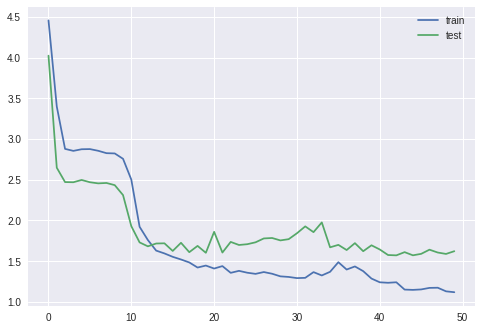

In [0]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Predict 6C but was 6C / 3.4730050563812256 round to 3 expect 3 / diff 0
###
Predict 7A but was 7A / 5.457200050354004 round to 5 expect 5 / diff 0
###
Predict 6B+ but was 6A+ / 1.7274690866470337 round to 2 expect 0 / diff 2
###
Predict 7A but was 7B / 5.49089241027832 round to 5 expect 7 / diff -2
###
Predict 7C but was 7B / 8.887965202331543 round to 9 expect 7 / diff 2
###
Predict 6B but was 6B / 0.9101604223251343 round to 1 expect 1 / diff 0
###
Predict 7B+ but was 7C / 7.883720874786377 round to 8 expect 9 / diff -1
###
Predict 6B but was 6B / 0.5531731247901917 round to 1 expect 1 / diff 0
###
Predict 6B+ but was 6A+ / 1.634559988975525 round to 2 expect 0 / diff 2
###
Predict 7A+ but was 7B / 6.267698287963867 round to 6 expect 7 / diff -1
###
Predict 6A+ but was 6B / 0.47010675072669983 round to 0 expect 1 / diff -1
###
Predict 7C but was 7B / 8.980155944824219 round to 9 expect 7 / diff 2
###
Predict 7C but was 7A+ / 8.906975746154785 round to 9 expect 6 / diff 3
###
Predict 

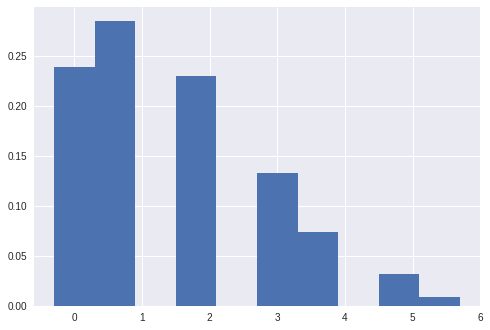

In [0]:
# make a prediction
predictions = model.predict(X_test)
meanAbsError = 0
maeDifferences = []

for i in range(0, len(predictions)):
  prediction = predictions[i][0]
  roundedPrediction = int(round(prediction))
  diff = roundedPrediction - y_test[i]
  meanAbsError += abs(diff)
  maeDifferences.append(abs(diff))
  print('Predict {} but was {} / {} round to {} expect {} / diff {}'.format(gradeIndex[roundedPrediction], gradeIndex[y_test[i]], prediction, roundedPrediction, y_test[i], diff))
  print("###")
  
print("MAE")
print(meanAbsError / len(predictions))

maeDifferences = np.array(maeDifferences)
hist, bins = np.histogram(maeDifferences)

pyplot.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
pyplot.plot()

print(maeDifferences)